<a href="https://colab.research.google.com/github/nfaggian/record_linkage/blob/master/link.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Record linkage 

## Dependencies
- - - 

Jellyfish is a library for comparing strings: [github](https://github.com/jamesturk/jellyfish )

In [1]:
!pip install jellyfish tqdm matplotlib

In [2]:
import numpy as np
import pandas as pd
import tqdm

import uuid

import jellyfish as jf
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import HTML, display, clear_output

## GCP authentication
- - - 

In [3]:
try: 
    from google.colab import auth
    auth.authenticate_user()
except:     
    try:
        import google.auth
        credentials, project = google.auth.default()
    except:
        raise Exception('Google cloud authentication required!')

/home/nfaggian/development/miniconda/envs/py3/lib/python3.7/site-packages/google/auth/_default.py:66: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not enabled" error. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [4]:
%env GOOGLE_CLOUD_PROJECT=anz-pso-nfaggian

project_id = 'anz-pso-nfaggian'

env: GOOGLE_CLOUD_PROJECT=anz-pso-nfaggian


## Retrieve donor and contributions data

In [6]:
query = f"""
SELECT
  * 
FROM
  dedup.donors
WHERE MOD(ABS(FARM_FINGERPRINT(CAST(donor_id AS STRING))), 1000) = 0
"""

raw_donors = pd.io.gbq.read_gbq(query, project_id=project_id, dialect='standard')
raw_donors = raw_donors.sort_values(by='donor_id')
print(raw_donors.shape)
raw_donors.head()

(726, 10)


,donor_id,last_name,first_name,address_1,address_2,city,state,zip,employer,occupation
220,404,1-28-07 cash deposits,None,None,None,None,il,None,None,None
548,422,12 congressional district afl-cio cope cont. fund,None,59 magnolia dr.,None,belleville,il,62221,None,None
295,616,1420 west lexington partnership,None,1420 west lexington partnership,None,chicago,il,60607,None,None
309,988,18th ward democratic org,None,8150 s kedzie ave,None,chicago,il,60652,None,None
300,2158,35th & indiana currency exchange,None,126 e. 35th street,None,chicago,il,60616,None,None


In [7]:
query = f"""
SELECT
  donor_id, amount
FROM
  dedup.contributions
WHERE MOD(ABS(FARM_FINGERPRINT(CAST(donor_id AS STRING))), 1000) = 0
"""

raw_donations = pd.io.gbq.read_gbq(query, project_id=project_id, dialect='standard')
raw_donations = raw_donations.sort_values(by='donor_id')
print(raw_donations.shape)
raw_donations.head()

(1662, 2)


,donor_id,amount
1483,404,129.0
543,422,300.0
879,616,600.0
346,988,200.0
1052,2158,500.0


**Data preperation**
- - - 

In [8]:
def transform(record):
  """
  Perform some simple transformations on the record.
  """
  
  # combine the first and last name
  return {
      'donor_id': record.donor_id,
          'city': f"{record.city or ' '}".strip().lower(),
          'name': f"{record.first_name or ' '} {record.last_name or ' '}".strip().lower(),
       'address': f"{record.address_1 or ' '} {record.address_2 or ' '}".strip().lower(), 
         'state': f"{record.state or ' '}".strip().lower(),
           'zip': f"{record.zip or ' '}".strip().lower(),
    'occupation': f"{record.occupation or ' '}".strip().lower(),
      'employer': f"{record.employer or ' '}".strip().lower(),
     'is_person': record.first_name is not None }

In [9]:
donors = [] 
for row, record in tqdm.tqdm(raw_donors.iterrows(), total=raw_donors.shape[0]):
    donors.append(transform(record))
donors = pd.DataFrame(donors)
donors.head()

100%|██████████| 726/726 [00:00<00:00, 1722.92it/s]


,address,city,donor_id,employer,is_person,name,occupation,state,zip
0,,,404,,False,1-28-07 cash deposits,,il,
1,59 magnolia dr.,belleville,422,,False,12 congressional district afl-cio cope cont. fund,,il,62221
2,1420 west lexington partnership,chicago,616,,False,1420 west lexington partnership,,il,60607
3,8150 s kedzie ave,chicago,988,,False,18th ward democratic org,,il,60652
4,126 e. 35th street,chicago,2158,,False,35th & indiana currency exchange,,il,60616


## Comparing duplicated donor data
- - -

In [8]:
data = []

def comparator(record_a, record_b):
  """
  Compares one field to another, using a series of distance metrics.
  """
  
  return {
    'donor_id1': record_a.donor_id,
    'donor_id2': record_b.donor_id,
    # name
    'jaro_name': jf.jaro_winkler(record_a['name'], record_b['name']),
    'phonetic_name': jf.match_rating_comparison(record_a['name'], record_b['name']),
    'damerau_name': jf.damerau_levenshtein_distance(record_a['name'], record_b['name']),
    # address  
    'jaro_address': jf.jaro_winkler(record_a['address'], record_b['address']),
    'phonetic_address': jf.match_rating_comparison(record_a['address'], record_b['address']),  
    'damerau_address': jf.damerau_levenshtein_distance(record_a['address'], record_b['address']),  
    # city
    'jaro_city': jf.jaro_winkler(record_a['city'], record_b['city']),  
    'damerau_city': jf.damerau_levenshtein_distance(record_a['city'], record_b['city']),  
    # occupation
    'jaro_occupation': jf.jaro_winkler(record_a['occupation'], record_b['occupation']),
    'damerau_occupation': jf.damerau_levenshtein_distance(record_a['occupation'], record_b['occupation']),
    # state
    'jaro_state': jf.jaro_winkler(record_a['state'], record_b['state']),
    'damerau_state': jf.damerau_levenshtein_distance(record_a['state'], record_b['state'])
  }


In [10]:
distance_table = []
for row_a, record_a in tqdm.tqdm(donors.iterrows(), total=donors.shape[0]):
      for row_b, record_b in donors.iterrows():
            if row_a == row_b: continue    
            distance_table.append(comparator(record_a, record_b)) 
distance_table = pd.DataFrame(distance_table)

100%|██████████| 726/726 [12:06<00:00,  1.04it/s]


In [11]:
distance_table = distance_table.sort_values(by='jaro_name', ascending=False)

From the dataset (in the small sample) we can see that the patterns of similarity:

* Using the jaro-winkler distance we can see that there are patches of highly similary values (close to 1). 
* Using the damerau distance the patterns are a bit different, it is more sensitive to larger edits and unbound. 

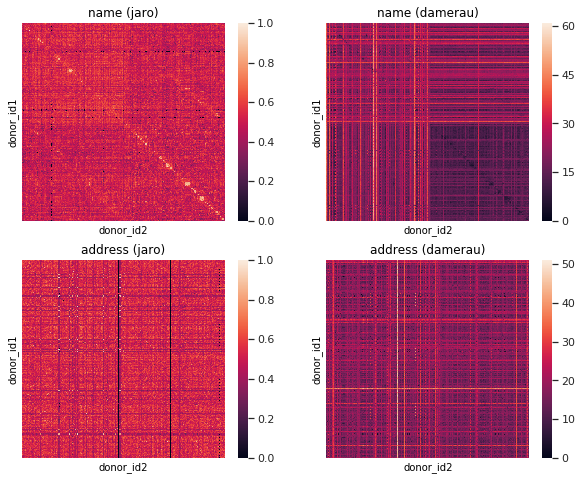

In [12]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 8))
sns.set(style="ticks")
sns.heatmap(distance_table.pivot('donor_id1', 'donor_id2', 'jaro_name'), 
            xticklabels=False, yticklabels=False, annot=False, ax=ax1)
ax1.set_title('name (jaro)')
sns.heatmap(distance_table.pivot('donor_id1', 'donor_id2', 'damerau_name'), 
            xticklabels=False, yticklabels=False, annot=False, ax=ax2)
ax2.set_title('name (damerau)')
sns.heatmap(distance_table.pivot('donor_id1', 'donor_id2', 'jaro_address'), 
            xticklabels=False, yticklabels=False, annot=False, ax=ax3)
ax3.set_title('address (jaro)')
sns.heatmap(distance_table.pivot('donor_id1', 'donor_id2', 'damerau_address'), 
            xticklabels=False, yticklabels=False, annot=False, ax=ax4)
ax4.set_title('address (damerau)');


## Building a simple baseline model
- - -

Using the metrics we just calculated - let us build a simple duplicate detector, based on the following rules:

* jaro distances which are closer to 1.0 are good examples of duplicates.
* damerau distances which are closer to zero are good example of duplicates. 

We can set this threshold by looking at the distribution of the distance metrics for our small dataset, under the assumption that our small sample contains some of the common errors we will see in the larger dataset.

/home/nfaggian/development/miniconda/envs/py3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


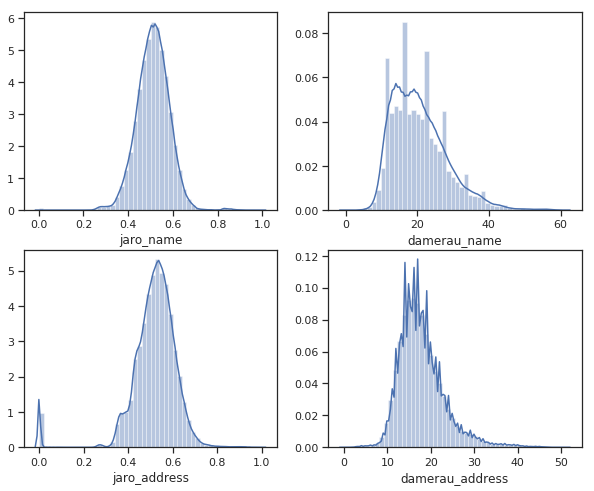

In [13]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 8))
sns.set(style="ticks")
sns.distplot(distance_table['jaro_name'], ax=ax1)
sns.distplot(distance_table['damerau_name'], ax=ax2)
sns.distplot(distance_table['jaro_address'], ax=ax3)
sns.distplot(distance_table['damerau_address'], ax=ax4);

In [14]:
print(f"""
 jaro_name    :{distance_table['jaro_name'].quantile(0.99)}
 jaro_address :{distance_table['jaro_address'].quantile(0.99)}
 damerau_name    :{distance_table['damerau_name'].quantile(0.01)}
 damerau_address :{distance_table['damerau_address'].quantile(0.01)}
""") 


 jaro_name    :0.6725895863395869
 jaro_address :0.7111111111111111
 damerau_name    :9.0
 damerau_address :9.0



Using the mean operator we can form a simple classifier that assumes equal importance of each distance metric:

In [15]:
def baseline_classifier(record):
    """
    Simple voting classifier.
    * assumes an equal weighting for the different types of distance metrics. 
    """
    votes = [
        record['jaro_name'] > 0.67,
        record['jaro_address'] > 0.67,
        record['damerau_name'] < 9,
        record['damerau_address'] < 9]
    return np.mean(votes)    

## Using the baseline model

In [16]:
classification_column = []
for row, record in tqdm.tqdm(distance_table.iterrows(), total=distance_table.shape[0]):
  classification_column.append(baseline_classifier(record))

100%|██████████| 526350/526350 [03:08<00:00, 2796.07it/s]


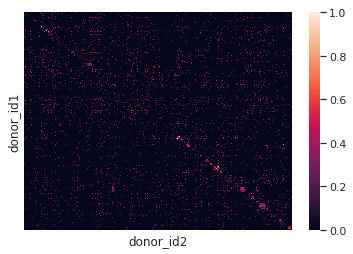

In [17]:
distance_table['duplicate'] = np.array(classification_column) > 0.5
distance_table['duplicate_score'] = np.array(classification_column)

sns.heatmap(distance_table.pivot('donor_id1', 'donor_id2', 'duplicate_score'), 
            xticklabels=False, yticklabels=False, annot=False);

## Clustering
- - -

Using a "greedy" clustering algorithm we can form a distinct set of clustered records. We restrict the donors to one distinct cluster and ignore potential overlaps. 

In [19]:
redux = distance_table[['donor_id1', 'donor_id2', 'duplicate', 'duplicate_score']]

donor_map = {}

duplicates = set([])

for donor_id, frame in redux.groupby(['donor_id1']):
  
    if donor_id in duplicates: continue
  
    # Form a unique identifier
    cluster_id = uuid.uuid4()
    donor_map[donor_id] = cluster_id
  
    # Map the donor_ids in the cluster to the same cluster identifier
    for matched_donor in frame[frame['duplicate']]['donor_id2']:
        donor_map[matched_donor] = cluster_id
        duplicates.add(matched_donor)

After forming a new identifier for clusters we can add them to the donor and donation tables.

In [20]:
raw_donations['cluster_id'] = raw_donations['donor_id'].apply(lambda x: donor_map[x])

donors['cluster_id'] = donors['donor_id'].apply(lambda x: donor_map[x])

## Solving the problem (reduced set)

- - - 

On the reduced dataset using the **donor identifier**:

In [21]:
top_donations = raw_donations.pivot_table(index='donor_id', aggfunc=sum)[['amount']].sort_values('amount', ascending=False).head(10).reset_index()

pd.merge(top_donations, donors, on='donor_id')[['name', 'amount']].head(10)

,name,amount
0,upspac,109950.00
1,chicago & northeast il dist - carpenters pac,109000.00
2,kimball hill inc.,37900.00
3,k-five construction,32978.01
4,manufacturer's political action comm.,24000.00
5,chicago & ne ii dist. council carpenters,22250.00
6,chicago fire fighters union,21200.00
7,stroger citizens for,18500.00
8,frank novotny & assoc. inc.,17650.00
9,rosemont leasing,17290.00


On the reduced dataset using the newly formed **cluster identifier**:

In [22]:
top_donations = raw_donations.pivot_table(index='cluster_id', aggfunc=sum)[['amount']].sort_values('amount', ascending=False).head(10).reset_index()

pd.merge(top_donations, donors, on='cluster_id')[['name', 'amount']].head(10)


,name,amount
0,chicago & northeast il dist - carpenters pac,110000.00
1,solum & hopper attorneys and counselors at law,110000.00
2,upspac,109950.00
3,chicago fire fighters union,43950.00
4,chicago fire fighters union local # 2 pac,43950.00
5,chicago & ne ii dist. council carpenters,43950.00
6,kimball hill inc.,37900.00
7,k-five construction,32978.01
8,manufacturer's political action comm.,24000.00
9,stroger citizens for,18500.00


# Next steps



## Building more complicated models
- - -

To build a more complicated classifier we need to first label some training data:

In [ ]:
duplicate_set = set([])

for row, comparison in distance_table.iterrows():
    
    id1, id2 = comparison['donor_id1'], comparison['donor_id2']
    
    comparison_frame = donors[(donors.donor_id == id1) | (donors.donor_id == id2)].reset_index()
    
    display(HTML(comparison_frame.to_html()))
    
    duplicate_test = input('Is this a duplicate? (y,n,s)')
    
    if 's' in duplicate_test: 
      clear_output
      break
   
    if 'y' in duplicate_test: 
      duplicate_set.update([id1, id2])  
      clear_output()
    